In [1]:
#|export
from tsai.imports import *
from tsai.models.layers import *
from torchinfo import summary

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from scipy import signal
# from tqdm.notebook import tqdm

import torch.nn.functional as F
from collections import OrderedDict

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# hyper parameter
num_classes = 30
close_num = 14 # 14, 19, 24, 29 0~14で15個の意味
batch_size = 64
learning_rate = 0.0001
num_epochs = 100
down_ratio = 8
sequence_len = 2000 * 5 // down_ratio # default 2000Hz
overlap = int(sequence_len * 0.3)
threshold = 0.9
thresholds = [0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
close_nums = [14, 19, 24, 29]
alpha = 0.1

In [6]:
radar_frame_list = []
scaler = MinMaxScaler((-1, 1)) # or StandardScaler

for i in range(1, num_classes + 1):
    # wave_2d = [] # input need to be 2d?
    file_path = "./data/radar_%02d.csv" % i # or ./data/radar_%02d
    radar_frame = pd.read_csv(file_path)
    wave = radar_frame.to_numpy().flatten()
    wave = signal.decimate(wave, down_ratio) # down sampling
    
    end = len(wave)
    n = 0
    n_stop = sequence_len
    wave_segments = []

    while n_stop < end:
        n_start = 0 + ((sequence_len - 1) - (overlap - 1)) * n
        n_stop = n_start + sequence_len
        tmp = []
        seg = wave[n_start:n_stop].copy()
        wave_segments.append([seg])
        n += 1
    
    radar_frame_list.append(wave_segments)

data_df = pd.DataFrame(radar_frame_list)

In [45]:
labels = []
for i in range(len(radar_frame_list)):
    for j in range(len(radar_frame_list[i])):
        if i <= close_num:
            labels.append(i)
        else:
            labels.append(close_num + 1)

labels_series = pd.Series(labels)

In [8]:
tmp = data_df.to_numpy().flatten().copy()
data_series = pd.Series(tmp).dropna() # remove None (keys are as they are)
tmp = data_series.to_numpy().flatten()

tmp_labels = labels_series.to_numpy().flatten()
# len(tmp) = 5442 (30人分のデータ)
# len(tmp[0]) = 1 (in_channelが1のため)
# len(tmp[0][0]) = 1250 (sequence_len)

for i in reversed(range(len(tmp))):
  if len(tmp[i][0]) != sequence_len:
    # print(i, len(tmp[i][0]))
    tmp = np.delete(tmp, i)
    tmp_labels = np.delete(tmp_labels, i)

data_series = pd.Series(tmp)
labels_series = pd.Series(tmp_labels)
labels_tensor = torch.tensor(labels_series)
data_series.shape, labels_tensor, labels_tensor.shape

((5413,), tensor([ 0,  0,  0,  ..., 15, 15, 15]), torch.Size([5413]))

In [9]:
#|export
class MiniRocketFeatures(nn.Module):
    """This is a Pytorch implementation of MiniRocket developed by Malcolm McLean and Ignacio Oguiza
    
    MiniRocket paper citation:
    @article{dempster_etal_2020,
      author  = {Dempster, Angus and Schmidt, Daniel F and Webb, Geoffrey I},
      title   = {{MINIROCKET}: A Very Fast (Almost) Deterministic Transform for Time Series Classification},
      year    = {2020},
      journal = {arXiv:2012.08791}
    }
    Original paper: https://arxiv.org/abs/2012.08791
    Original code:  https://github.com/angus924/minirocket"""

    kernel_size, num_kernels, fitting = 9, 84, False

    def __init__(self, c_in, seq_len, num_features=10_000, max_dilations_per_kernel=32, random_state=None):
        super(MiniRocketFeatures, self).__init__()
        self.c_in, self.seq_len = c_in, seq_len
        self.num_features = num_features // self.num_kernels * self.num_kernels
        self.max_dilations_per_kernel  = max_dilations_per_kernel
        self.random_state = random_state

        # Convolution
        indices = torch.combinations(torch.arange(self.kernel_size), 3).unsqueeze(1)
        kernels = (-torch.ones(self.num_kernels, 1, self.kernel_size)).scatter_(2, indices, 2)
        self.kernels = nn.Parameter(kernels.repeat(c_in, 1, 1), requires_grad=False)

        # Dilations & padding
        self._set_dilations(seq_len)

        # Channel combinations (multivariate)
        if c_in > 1:
            self._set_channel_combinations(c_in)

        # Bias
        for i in range(self.num_dilations):
            self.register_buffer(f'biases_{i}', torch.empty((self.num_kernels, self.num_features_per_dilation[i])))
        self.register_buffer('prefit', torch.BoolTensor([False]))
        
    def fit(self, X, chunksize=None):
        num_samples = X.shape[0]
        if chunksize is None:
            chunksize = min(num_samples, self.num_dilations * self.num_kernels)
        else: 
            chunksize = min(num_samples, chunksize)
        np.random.seed(self.random_state)
        idxs = np.random.choice(num_samples, chunksize, False)
        self.fitting = True
        if isinstance(X, np.ndarray): 
            self(torch.from_numpy(X[idxs]).to(self.kernels.device))
        else:
            self(X[idxs].to(self.kernels.device))
        self.fitting = False
    
    def forward(self, x):
        _features = []
        for i, (dilation, padding) in enumerate(zip(self.dilations, self.padding)):
            _padding1 = i%2
            
            # Convolution
            C = F.conv1d(x, self.kernels, padding=padding, dilation=dilation, groups=self.c_in)
            if self.c_in > 1: # multivariate
                C = C.reshape(x.shape[0], self.c_in, self.num_kernels, -1)
                channel_combination = getattr(self, f'channel_combinations_{i}')
                C = torch.mul(C, channel_combination)
                C = C.sum(1)

            # Bias
            if not self.prefit or self.fitting:
                num_features_this_dilation = self.num_features_per_dilation[i]
                bias_this_dilation = self._get_bias(C, num_features_this_dilation)
                setattr(self, f'biases_{i}', bias_this_dilation)        
                if self.fitting:
                    if i < self.num_dilations - 1:
                        continue
                    else:
                        self.prefit = torch.BoolTensor([True])
                        return
                elif i == self.num_dilations - 1:
                    self.prefit = torch.BoolTensor([True])
            else:
                bias_this_dilation = getattr(self, f'biases_{i}')
            
            # Features
            _features.append(self._get_PPVs(C[:, _padding1::2], bias_this_dilation[_padding1::2]))
            _features.append(self._get_PPVs(C[:, 1-_padding1::2, padding:-padding], bias_this_dilation[1-_padding1::2]))
        return torch.cat(_features, dim=1)           

    def _get_PPVs(self, C, bias):
        C = C.unsqueeze(-1)
        bias = bias.view(1, bias.shape[0], 1, bias.shape[1])
        return (C > bias).float().mean(2).flatten(1)

    def _set_dilations(self, input_length):
        num_features_per_kernel = self.num_features // self.num_kernels
        true_max_dilations_per_kernel = min(num_features_per_kernel, self.max_dilations_per_kernel)
        multiplier = num_features_per_kernel / true_max_dilations_per_kernel
        max_exponent = np.log2((input_length - 1) / (9 - 1))
        dilations, num_features_per_dilation = \
        np.unique(np.logspace(0, max_exponent, true_max_dilations_per_kernel, base = 2).astype(np.int32), return_counts = True)
        num_features_per_dilation = (num_features_per_dilation * multiplier).astype(np.int32)
        remainder = num_features_per_kernel - num_features_per_dilation.sum()
        i = 0
        while remainder > 0:
            num_features_per_dilation[i] += 1
            remainder -= 1
            i = (i + 1) % len(num_features_per_dilation)
        self.num_features_per_dilation = num_features_per_dilation
        self.num_dilations = len(dilations)
        self.dilations = dilations
        self.padding = []
        for i, dilation in enumerate(dilations): 
            self.padding.append((((self.kernel_size - 1) * dilation) // 2))

    def _set_channel_combinations(self, num_channels):
        num_combinations = self.num_kernels * self.num_dilations
        max_num_channels = min(num_channels, 9)
        max_exponent_channels = np.log2(max_num_channels + 1)
        np.random.seed(self.random_state)
        num_channels_per_combination = (2 ** np.random.uniform(0, max_exponent_channels, num_combinations)).astype(np.int32)
        channel_combinations = torch.zeros((1, num_channels, num_combinations, 1))
        for i in range(num_combinations):
            channel_combinations[:, np.random.choice(num_channels, num_channels_per_combination[i], False), i] = 1
        channel_combinations = torch.split(channel_combinations, self.num_kernels, 2) # split by dilation
        for i, channel_combination in enumerate(channel_combinations): 
            self.register_buffer(f'channel_combinations_{i}', channel_combination) # per dilation

    def _get_quantiles(self, n):
        return torch.tensor([(_ * ((np.sqrt(5) + 1) / 2)) % 1 for _ in range(1, n + 1)]).float()

    def _get_bias(self, C, num_features_this_dilation):
        np.random.seed(self.random_state)
        idxs = np.random.choice(C.shape[0], self.num_kernels)
        samples = C[idxs].diagonal().T 
        biases = torch.quantile(samples, self._get_quantiles(num_features_this_dilation).to(C.device), dim=1).T
        return biases

MRF = MiniRocketFeatures

In [10]:
#|export 
def get_minirocket_features(o, model, chunksize=1024, use_cuda=None, to_np=True):
    """Function used to split a large dataset into chunks, avoiding OOM error."""
    use = torch.cuda.is_available() if use_cuda is None else use_cuda
    device = torch.device(torch.cuda.current_device()) if use else torch.device('cpu')
    model = model.to(device)
    if isinstance(o, np.ndarray): o = torch.from_numpy(o).to(device)
    _features = []
    for oi in torch.split(o, chunksize): 
        _features.append(model(oi))
    features = torch.cat(_features).unsqueeze(-1)
    if to_np: return features.cpu().numpy()
    else: return features

In [11]:
#|export
class MiniRocket(nn.Sequential):
    def __init__(self, c_in, c_out, seq_len, num_features=10_000, max_dilations_per_kernel=32, random_state=None, bn=True, fc_dropout=0):
        
        # Backbone
        backbone =  MiniRocketFeatures(c_in, seq_len, num_features=num_features, max_dilations_per_kernel=max_dilations_per_kernel, 
                                       random_state=random_state)
        num_features = backbone.num_features

        # Head
        self.head_nf = num_features
        layers = [nn.Flatten()]
        if bn: layers += [nn.BatchNorm1d(num_features)]
        if fc_dropout: layers += [nn.Dropout(fc_dropout)]   
        linear = nn.Linear(num_features, c_out)
        nn.init.constant_(linear.weight.data, 0)
        nn.init.constant_(linear.bias.data, 0) 
        layers += [linear]
        head = nn.Sequential(*layers)

        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))

    def fit(self, X, chunksize=None):
        self.backbone.fit(X, chunksize=chunksize)

In [12]:
#|export
class MiniRocketHead(nn.Sequential):
    def __init__(self, c_in, c_out, seq_len=1, bn=True, fc_dropout=0.):
        layers = [nn.Flatten()]
        if bn:
            layers += [nn.BatchNorm1d(c_in)]
        if fc_dropout:
            layers += [nn.Dropout(fc_dropout)]
        linear = nn.Linear(c_in, c_out)
        nn.init.constant_(linear.weight.data, 0)
        nn.init.constant_(linear.bias.data, 0)
        layers += [linear]
        head = nn.Sequential(*layers)
        super().__init__(OrderedDict(
            [('backbone', nn.Sequential()), ('head', head)]))

In [13]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, root_dir, transform=None) -> None:
        # super().__init__()
        self.radar_heartbeat = dataset
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        onehot_label = torch.eye(num_classes)[self.labels[idx] - 1] # one hot encodingは不要らしい　精度悪い場合試す必要あり
        # one_hot = torch.nn.functional.one_hot(self.labels, num_classes=num_classes)
        return torch.tensor(self.radar_heartbeat[idx]), self.labels[idx] # labels is already tensor (converted in preparation phase)
        # return torch.tensor(self.radar_heartbeat[idx]), onehot_label

    def __len__(self):
        return len(self.radar_heartbeat)


dataset = MyDataset(data_series, labels_tensor, "./data/", transform=transforms.ToTensor())

In [27]:
indices1

array([   0,    1,    2, ..., 2688, 2689, 2690])

In [30]:
type(torch.tensor(dataset.radar_heartbeat))

torch.Tensor

In [14]:
indices1 = np.arange(2691)
dataset1 = torch.utils.data.Subset(dataset, indices1) # 0-14
indices2 = np.arange(2692, len(dataset))
dataset2 = torch.utils.data.Subset(dataset, indices2) # 15-29
Unknown_label = close_num + 1

In [15]:
train_size1 = int(0.80 * len(dataset1))
test_size1 = len(dataset1) - train_size1

train_size2 = int(0.80 * len(dataset2))
test_size2 = len(dataset2) - train_size2

open_train_set, test_set1 = torch.utils.data.random_split(dataset1, [train_size1, test_size1])
train_set2, test_set2 = torch.utils.data.random_split(dataset2, [train_size2, test_size2])

indices = np.arange(len(test_set2))
test_set2 = torch.utils.data.Subset(test_set2, indices[:])

In [16]:
open_test_set = torch.utils.data.ConcatDataset([test_set1, test_set2])
len(open_train_set), len(open_test_set)

(2152, 1084)

In [17]:
train_loader = DataLoader(dataset=open_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=open_test_set, batch_size=batch_size, shuffle=False) # テストでシャッフルしても同じ、図示のためにshuffle(図示しないからFalse)

In [19]:
from torch import log
softmax = nn.Softmax()

def softmax_loss(outputs, labels):
    loss = 0
    batch_size = len(labels)
    logsoftmax_out = log(softmax(outputs))
    for idx in range(batch_size):
        loss += 1.0 - logsoftmax_out[idx][labels[idx]]
    
    return loss / batch_size


from center_loss import CenterLoss
center_loss = CenterLoss(num_classes=close_num + 1, feat_dim=close_num + 1, use_gpu=True) # 入出力が同じだと一見変な感じがするが，交差エントロピーと違ってcenterlossを使うと最初から決めていれば，モデルの出力サイズを必ずしもクラス数に一致させる必要がないからfeat_dimを任意に設定できる．
optimizer_centloss = torch.optim.SGD(center_loss.parameters(), lr=0.05)


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='cosface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss
        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599
        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 32.0 if not s else s
            self.m = 0.2 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.fc.to(device)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)
        # logを引き算に変えて計算
        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

cos_loss = AngularPenaltySMLoss(close_num + 1, close_num + 1, loss_type="cosface") # center_lossと同じ理由でin_featuresはクラス数でよい．


def triple_joint_loss(output, label, alpha):
    # alpha: hyper parameter
    output_only_truth = []
    for idx, x in enumerate(output):
        x = x[labels[idx]]
        x = torch.tensor(x).to(device)
        output_only_truth.append([x])
    output_only_truth = torch.tensor(output_only_truth)
    output_only_truth = output_only_truth.float()
    output_only_truth = output_only_truth.to(device)
    # print(output.is_cuda, output_only_truth.is_cuda, label.is_cuda)

    return softmax_loss(output, label) + alpha * center_loss(output, label)
    # return softmax_loss(output, label) + alpha * center_loss(output, label) + cos_loss(output, label)
    # return cos_loss(output_only_truth, label)

In [22]:
model = MiniRocket(1, close_num + 1) # 0-?+Unknownを出力　close num + 1でやっとclose setでは
model = model.to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### tsaiを使ってみる

In [ ]:
train_set, test_set = 

In [36]:
from tsai.basics import *
from sklearn.metrics import accuracy_score, mean_squared_error
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

In [37]:
mrf = MiniRocketFeatures(1, 5000).to(device)
X = torch.tensor(dataset.radar_heartbeat).float().to(device)
X_train = torch.tensor(dataset.radar_heartbeat)[:2691].float()
mrf.fit(X_train)
X_feat = get_minirocket_features(X, mrf, chunksize=1024, to_np=True)
X_feat.shape, type(X_feat)

((5413, 9996, 1), numpy.ndarray)

In [44]:
y.shape

torch.Size([64])

In [38]:
PATH = Path("./models/MRF.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)

#### splits = (train_idx, val_idx)

In [49]:
len(labels)

5442

In [54]:
type(indices1[0])

numpy.int64

epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.994489,00:00
1,nan,nan,0.994489,00:00
2,nan,nan,0.994489,00:00
3,nan,nan,0.994489,00:00
4,nan,nan,0.994489,00:00
5,nan,nan,0.994489,00:00
6,nan,nan,0.994489,00:00
7,nan,nan,0.994489,00:00
8,nan,nan,0.994489,00:00
9,nan,nan,0.994489,00:00


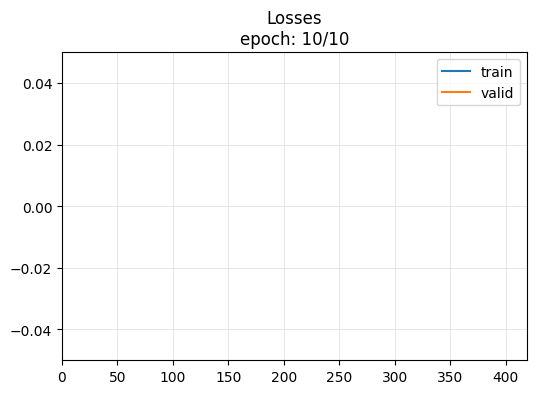

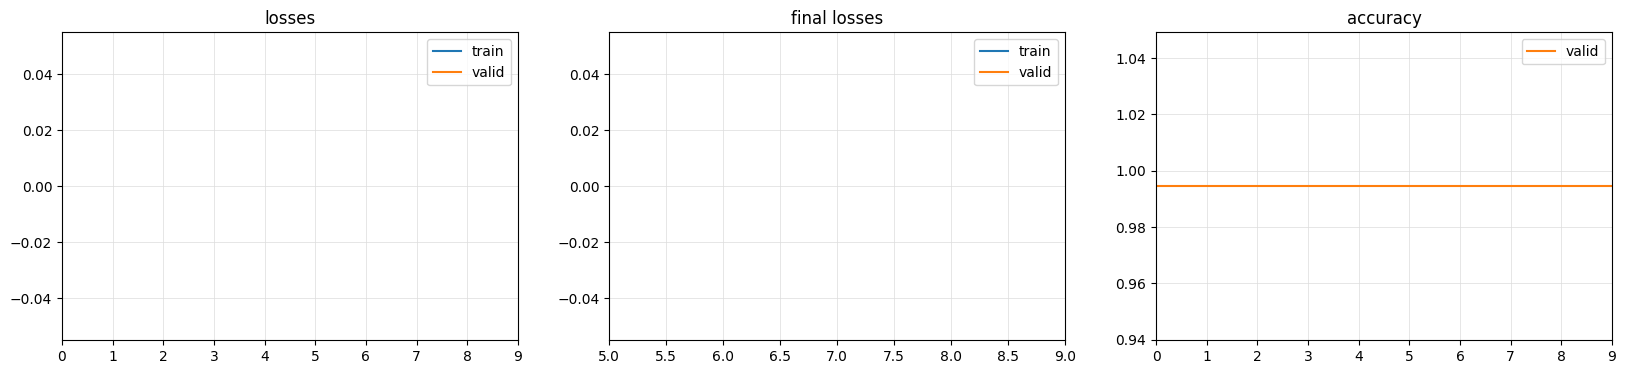

In [59]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
train_idx = [i for i in range(2690)]
val_idx = [i for i in range(2691, len(dataset))]
splits = (train_idx, val_idx)
y = labels
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)

# model is a linear classifier Head
model = build_ts_model(MiniRocketHead, dls=dls)

# Drop into fastai and use it to find a good learning rate.
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())

learn.fit_one_cycle(10, 3e-4)


In [23]:
model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (signals, labels) in enumerate(train_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    labels = labels.to(device)

    # print(signals.size())
    outputs = model(signals)
    outputs = outputs.to(device)
    # print(outputs)
    loss = triple_joint_loss(outputs, labels, alpha) # will check the shapes of outputs and labels

    optimizer.zero_grad()
    optimizer_centloss.zero_grad()
    loss.backward()
    for param in center_loss.parameters():
      param.grad.data *= (1./alpha) # 98.98%を出したときはこれを書いていなかった→追加しても問題なし．
    optimizer.step()
    optimizer_centloss.step()
    if (i + 1) % 12 == 0:
      print(f'Epoch [{epoch+1}/`{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

/tmp/ipykernel_881/3184224251.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals)
/tmp/ipykernel_881/3433469541.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(device)
/tmp/ipykernel_881/3433469541.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logsoftmax_out = log(softmax(outputs))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x9996 and 15x15)

In [ ]:
# For Confusion Matrix
predicted_lists = np.zeros(0, dtype=np.int64)
one_hot_labels_list = np.zeros(0, dtype=np.int64)
model.eval()

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  softmax = nn.Softmax()
  for i, (signals, one_hot_labels) in enumerate(test_loader):
    signals = torch.tensor(signals)
    signals = signals.float()
    signals = signals.to(device)
    one_hot_labels = one_hot_labels.to(device)
    # print(len(one_hot_labels))
    outputs = model(signals)
    if i == 1:
      print(outputs)
    for j, out in enumerate(outputs):
      outputs[j] = softmax(out)

    _, predicted = torch.max(outputs.data, 1) # predicted per batch size
    
    
    for idx in range(len(_)):
      if _[idx] < threshold:
        predicted[idx] = Unknown_label # 15, 20, 25
    print(_, predicted, one_hot_labels)

    n_samples += one_hot_labels.size(0) # add batch_size
    n_correct += (predicted == one_hot_labels).sum().item()
    
    predicted_cp = predicted.to('cpu').detach().numpy().copy()
    one_hot_labels_cp = one_hot_labels.to('cpu').detach().numpy().copy()
    predicted_lists = np.concatenate([predicted_lists, predicted_cp])
    one_hot_labels_list = np.concatenate([one_hot_labels_list, one_hot_labels_cp])
    
    acc = 100.0 * n_correct / n_samples
    print(f'{n_correct} / {n_samples} = Acc: {acc} %')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(one_hot_labels_list, predicted_lists)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("Ground Truth", fontsize=13)
fig_name = "sklearn_confusion_matrix_{}_{}.png".format(Unknown_label, threshold)
# plt.savefig("./figure/" + fig_name)